# PHOEBE G/F SpT Physical Grid Full

Code for generating grid of G/F spectral type stars to see the impact on eclipse width, depth as well as the impact on measured colour.
Go to 22/01/2026 in Notebook for notes.

## Import dependances

In [1]:
import phoebe as phb, numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from astropy import units as u
from scipy.interpolate import UnivariateSpline

import sys
sys.path.append('../')
from Functions.phoebeCustom import saveSimulation, normaliseFluxes

## Initalise Binary

Initialise PHOEBE with the default binary + warnings

In [2]:
logger = phb.logger('error')
bSystem = phb.default_binary()

## Control Elements

These should stay the same as they shouldn't have any impact on the lightcurve.

In [3]:
period = 10
times = phb.linspace(0, period, 2001)

In [4]:
bSystem['period@binary'] = period
bSystem['distance@system'] = 10 * u.astrophys.pc
print(bSystem['distance@system'])

Parameter: distance@system
                       Qualifier: distance
                     Description: Distance to the system
                           Value: 3.085677581491367e+17 m
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [5]:
bSystem.flip_constraint('mass@primary', 'sma@binary')
bSystem.flip_constraint('mass@secondary', 'q')

<ConstraintParameter: {q@binary@component} = {mass@secondary@component} / {mass@primary@component} (solar units) => 1.0>

## Parameter space initialisaton

Initialise the parameter space for all spectral types

In [6]:
spT = ['K4', 'K3', 'K2', 'K1', 'K0', 'G9', 'G8', 'G7', 'G6', 'G5', 'G4', 'G3', 'G2', 'G1', 'G0', 'F9', 'F8', 'F7', 'F6', 'F5'] # Spectral type
masses = [0.73, 0.78, 0.82, 0.86, 0.88, 0.90, 0.94, 0.95, 0.97, 0.98, 0.985, 0.99, 1.00, 1.03, 1.06, 1.13, 1.18, 1.21, 1.25, 1.33] # In solar masses
radii = [0.713, 0.755, 0.783, 0.797, 0.813, 0.853, 0.914, 0.927, 0.949, 0.977, 0.991, 1.002, 1.012, 1.060, 1.100, 1.167, 1.221, 1.324, 1.359, 1.473] # In solar radius
teff = [4.60, 4.83, 5.10, 5.17, 5.27, 5.38, 5.48, 5.55, 5.60, 5.66, 5.68, 5.72, 5.78, 5.86, 5.93, 6.05, 6.18, 6.28, 6.35, 6.55] # In kiloKelvin 

df = pd.DataFrame({'Spectral Type' : spT, 'Temperature' : teff, 'Radius' : radii, 'Mass' : masses})
df

,Spectral Type,Temperature,Radius,Mass
0,K4,4.60,0.713,0.730
1,K3,4.83,0.755,0.780
2,K2,5.10,0.783,0.820
3,K1,5.17,0.797,0.860
4,K0,5.27,0.813,0.880
5,G9,5.38,0.853,0.900
6,G8,5.48,0.914,0.940
7,G7,5.55,0.927,0.950
8,G6,5.60,0.949,0.970
9,G5,5.66,0.977,0.980


## Simulation 

### Light Curve Datasets

Create the light curve datasets to be used in the simulation.

First, check installed passbands and install any needed. Then generate data sets.

In [7]:
print(phb.list_installed_passbands())
# phb.install_passband('johnson_b.fits', local=False)

['Bolometric:900-40000', 'Johnson:B', 'Johnson:V']


In [8]:
passbands = ['Johnson:B', 'Johnson:V']

for passband in passbands:
    bSystem.add_dataset(
        'lc', 
        times = times,
        passband=passband,
        dataset=f'lc_{passband[-1]}',
        overwrite=True
    )

bSystem.set_value_all('pblum_mode', 'absolute')
print('Datasets created.')

Datasets created.


### Main Loop

In [9]:
def centered_window(data, size=5):
    padding = size // 2
    extended_data = [None] * padding + data + [None] * padding
    
    for i in range(len(data)):
        yield extended_data[i : i + size]
        
indexes = list(range(len(spT)))

In [13]:
size = 7
file = '2026.02.05/'

for idx, star_slice in enumerate(centered_window(indexes, size)):
    prim_SpT, prim_T, prim_R, prim_M = df.loc[idx]
    print("\n------------------------------")
    print(f'\nPrimary: {prim_SpT} | Teff: {prim_T} | Radius: {prim_R} | Mass: {prim_M}')

    # Primary star config
    bSystem['component@primary@teff'] = prim_T * 1e3
    bSystem['component@primary@requiv'] = prim_R
    bSystem['component@primary@mass'] = prim_M
    
    # Remove previous models
    bSystem.remove_models_all()
    
    for j in star_slice:
        if j == None: continue # Loop over padding
        sec_SpT, sec_T, sec_R, sec_M = df.loc[j]
        print(f'\nSecondary: {sec_SpT} | Teff: {sec_T} | Radius: {sec_R} | Mass: {sec_M}')
        
         # Secondary star config
        bSystem['component@secondary@teff'] = sec_T * 1e3
        bSystem['component@secondary@requiv'] = sec_R
        bSystem['component@secondary@mass'] = sec_M
        
        bSystem.run_compute(
            model=sec_SpT,
            overwrite = True
        )
        
    bSystem.save(f'{file}grid_{prim_SpT}.phoebe', compact=True)
    



------------------------------

Primary: K4 | Teff: 4.6 | Radius: 0.713 | Mass: 0.73

Secondary: K4 | Teff: 4.6 | Radius: 0.713 | Mass: 0.73


100%|██████████| 2001/2001 [00:09<00:00, 201.16it/s]



Secondary: K3 | Teff: 4.83 | Radius: 0.755 | Mass: 0.78


100%|██████████| 2001/2001 [00:10<00:00, 198.93it/s]



Secondary: K2 | Teff: 5.1 | Radius: 0.783 | Mass: 0.82


100%|██████████| 2001/2001 [00:10<00:00, 199.48it/s]



Secondary: K1 | Teff: 5.17 | Radius: 0.797 | Mass: 0.86


100%|██████████| 2001/2001 [00:10<00:00, 194.70it/s]



------------------------------

Primary: K3 | Teff: 4.83 | Radius: 0.755 | Mass: 0.78

Secondary: K4 | Teff: 4.6 | Radius: 0.713 | Mass: 0.73


100%|██████████| 2001/2001 [00:10<00:00, 191.39it/s]



Secondary: K3 | Teff: 4.83 | Radius: 0.755 | Mass: 0.78


100%|██████████| 2001/2001 [00:10<00:00, 196.71it/s]



Secondary: K2 | Teff: 5.1 | Radius: 0.783 | Mass: 0.82


100%|██████████| 2001/2001 [00:11<00:00, 177.24it/s]



Secondary: K1 | Teff: 5.17 | Radius: 0.797 | Mass: 0.86


100%|██████████| 2001/2001 [00:10<00:00, 184.92it/s]



Secondary: K0 | Teff: 5.27 | Radius: 0.813 | Mass: 0.88


100%|██████████| 2001/2001 [00:10<00:00, 184.19it/s]



------------------------------

Primary: K2 | Teff: 5.1 | Radius: 0.783 | Mass: 0.82

Secondary: K4 | Teff: 4.6 | Radius: 0.713 | Mass: 0.73


100%|██████████| 2001/2001 [00:10<00:00, 196.44it/s]



Secondary: K3 | Teff: 4.83 | Radius: 0.755 | Mass: 0.78


100%|██████████| 2001/2001 [00:12<00:00, 165.86it/s]



Secondary: K2 | Teff: 5.1 | Radius: 0.783 | Mass: 0.82


100%|██████████| 2001/2001 [00:10<00:00, 185.14it/s]



Secondary: K1 | Teff: 5.17 | Radius: 0.797 | Mass: 0.86


100%|██████████| 2001/2001 [00:10<00:00, 193.18it/s]



Secondary: K0 | Teff: 5.27 | Radius: 0.813 | Mass: 0.88


100%|██████████| 2001/2001 [00:10<00:00, 195.19it/s]



Secondary: G9 | Teff: 5.38 | Radius: 0.853 | Mass: 0.9


100%|██████████| 2001/2001 [00:10<00:00, 199.45it/s]



------------------------------

Primary: K1 | Teff: 5.17 | Radius: 0.797 | Mass: 0.86

Secondary: K4 | Teff: 4.6 | Radius: 0.713 | Mass: 0.73


100%|██████████| 2001/2001 [00:10<00:00, 186.85it/s]



Secondary: K3 | Teff: 4.83 | Radius: 0.755 | Mass: 0.78


100%|██████████| 2001/2001 [00:10<00:00, 196.06it/s]



Secondary: K2 | Teff: 5.1 | Radius: 0.783 | Mass: 0.82


100%|██████████| 2001/2001 [00:10<00:00, 196.08it/s]



Secondary: K1 | Teff: 5.17 | Radius: 0.797 | Mass: 0.86


100%|██████████| 2001/2001 [00:10<00:00, 191.17it/s]



Secondary: K0 | Teff: 5.27 | Radius: 0.813 | Mass: 0.88


100%|██████████| 2001/2001 [00:10<00:00, 186.05it/s]



Secondary: G9 | Teff: 5.38 | Radius: 0.853 | Mass: 0.9


100%|██████████| 2001/2001 [00:10<00:00, 194.53it/s]



Secondary: G8 | Teff: 5.48 | Radius: 0.914 | Mass: 0.94


100%|██████████| 2001/2001 [00:10<00:00, 196.10it/s]



------------------------------

Primary: K0 | Teff: 5.27 | Radius: 0.813 | Mass: 0.88

Secondary: K3 | Teff: 4.83 | Radius: 0.755 | Mass: 0.78


100%|██████████| 2001/2001 [00:10<00:00, 191.89it/s]



Secondary: K2 | Teff: 5.1 | Radius: 0.783 | Mass: 0.82


100%|██████████| 2001/2001 [00:10<00:00, 188.48it/s]



Secondary: K1 | Teff: 5.17 | Radius: 0.797 | Mass: 0.86


100%|██████████| 2001/2001 [00:10<00:00, 188.66it/s]



Secondary: K0 | Teff: 5.27 | Radius: 0.813 | Mass: 0.88


100%|██████████| 2001/2001 [00:10<00:00, 194.80it/s]



Secondary: G9 | Teff: 5.38 | Radius: 0.853 | Mass: 0.9


100%|██████████| 2001/2001 [00:10<00:00, 197.41it/s]



Secondary: G8 | Teff: 5.48 | Radius: 0.914 | Mass: 0.94


100%|██████████| 2001/2001 [00:10<00:00, 192.49it/s]



Secondary: G7 | Teff: 5.55 | Radius: 0.927 | Mass: 0.95


100%|██████████| 2001/2001 [00:10<00:00, 188.59it/s]



------------------------------

Primary: G9 | Teff: 5.38 | Radius: 0.853 | Mass: 0.9

Secondary: K2 | Teff: 5.1 | Radius: 0.783 | Mass: 0.82


100%|██████████| 2001/2001 [00:10<00:00, 191.58it/s]



Secondary: K1 | Teff: 5.17 | Radius: 0.797 | Mass: 0.86


100%|██████████| 2001/2001 [00:10<00:00, 192.09it/s]



Secondary: K0 | Teff: 5.27 | Radius: 0.813 | Mass: 0.88


100%|██████████| 2001/2001 [00:10<00:00, 195.80it/s]



Secondary: G9 | Teff: 5.38 | Radius: 0.853 | Mass: 0.9


100%|██████████| 2001/2001 [00:10<00:00, 185.58it/s]



Secondary: G8 | Teff: 5.48 | Radius: 0.914 | Mass: 0.94


100%|██████████| 2001/2001 [00:11<00:00, 175.61it/s]



Secondary: G7 | Teff: 5.55 | Radius: 0.927 | Mass: 0.95


100%|██████████| 2001/2001 [00:10<00:00, 188.98it/s]



Secondary: G6 | Teff: 5.6 | Radius: 0.949 | Mass: 0.97


100%|██████████| 2001/2001 [00:11<00:00, 178.98it/s]



------------------------------

Primary: G8 | Teff: 5.48 | Radius: 0.914 | Mass: 0.94

Secondary: K1 | Teff: 5.17 | Radius: 0.797 | Mass: 0.86


100%|██████████| 2001/2001 [00:10<00:00, 184.87it/s]



Secondary: K0 | Teff: 5.27 | Radius: 0.813 | Mass: 0.88


100%|██████████| 2001/2001 [00:10<00:00, 184.63it/s]



Secondary: G9 | Teff: 5.38 | Radius: 0.853 | Mass: 0.9


100%|██████████| 2001/2001 [00:10<00:00, 189.65it/s]



Secondary: G8 | Teff: 5.48 | Radius: 0.914 | Mass: 0.94


100%|██████████| 2001/2001 [00:10<00:00, 195.40it/s]



Secondary: G7 | Teff: 5.55 | Radius: 0.927 | Mass: 0.95


100%|██████████| 2001/2001 [00:10<00:00, 195.07it/s]



Secondary: G6 | Teff: 5.6 | Radius: 0.949 | Mass: 0.97


100%|██████████| 2001/2001 [00:12<00:00, 165.46it/s]



Secondary: G5 | Teff: 5.66 | Radius: 0.977 | Mass: 0.98


100%|██████████| 2001/2001 [00:10<00:00, 183.01it/s]



------------------------------

Primary: G7 | Teff: 5.55 | Radius: 0.927 | Mass: 0.95

Secondary: K0 | Teff: 5.27 | Radius: 0.813 | Mass: 0.88


100%|██████████| 2001/2001 [00:11<00:00, 173.52it/s]



Secondary: G9 | Teff: 5.38 | Radius: 0.853 | Mass: 0.9


100%|██████████| 2001/2001 [00:10<00:00, 191.42it/s]



Secondary: G8 | Teff: 5.48 | Radius: 0.914 | Mass: 0.94


100%|██████████| 2001/2001 [00:09<00:00, 202.41it/s]



Secondary: G7 | Teff: 5.55 | Radius: 0.927 | Mass: 0.95


100%|██████████| 2001/2001 [00:10<00:00, 194.11it/s]



Secondary: G6 | Teff: 5.6 | Radius: 0.949 | Mass: 0.97


100%|██████████| 2001/2001 [00:10<00:00, 194.13it/s]



Secondary: G5 | Teff: 5.66 | Radius: 0.977 | Mass: 0.98


100%|██████████| 2001/2001 [00:10<00:00, 197.21it/s]



Secondary: G4 | Teff: 5.68 | Radius: 0.991 | Mass: 0.985


100%|██████████| 2001/2001 [00:10<00:00, 189.95it/s]



------------------------------

Primary: G6 | Teff: 5.6 | Radius: 0.949 | Mass: 0.97

Secondary: G9 | Teff: 5.38 | Radius: 0.853 | Mass: 0.9


100%|██████████| 2001/2001 [00:10<00:00, 187.92it/s]



Secondary: G8 | Teff: 5.48 | Radius: 0.914 | Mass: 0.94


100%|██████████| 2001/2001 [00:10<00:00, 191.34it/s]



Secondary: G7 | Teff: 5.55 | Radius: 0.927 | Mass: 0.95


100%|██████████| 2001/2001 [00:10<00:00, 186.44it/s]



Secondary: G6 | Teff: 5.6 | Radius: 0.949 | Mass: 0.97


100%|██████████| 2001/2001 [00:10<00:00, 196.05it/s]



Secondary: G5 | Teff: 5.66 | Radius: 0.977 | Mass: 0.98


100%|██████████| 2001/2001 [00:10<00:00, 185.55it/s]



Secondary: G4 | Teff: 5.68 | Radius: 0.991 | Mass: 0.985


100%|██████████| 2001/2001 [00:10<00:00, 187.83it/s]



Secondary: G3 | Teff: 5.72 | Radius: 1.002 | Mass: 0.99


100%|██████████| 2001/2001 [00:11<00:00, 176.00it/s]



------------------------------

Primary: G5 | Teff: 5.66 | Radius: 0.977 | Mass: 0.98

Secondary: G8 | Teff: 5.48 | Radius: 0.914 | Mass: 0.94


100%|██████████| 2001/2001 [00:11<00:00, 181.85it/s]



Secondary: G7 | Teff: 5.55 | Radius: 0.927 | Mass: 0.95


100%|██████████| 2001/2001 [00:10<00:00, 193.62it/s]



Secondary: G6 | Teff: 5.6 | Radius: 0.949 | Mass: 0.97


100%|██████████| 2001/2001 [00:10<00:00, 191.65it/s]



Secondary: G5 | Teff: 5.66 | Radius: 0.977 | Mass: 0.98


100%|██████████| 2001/2001 [00:10<00:00, 189.18it/s]



Secondary: G4 | Teff: 5.68 | Radius: 0.991 | Mass: 0.985


100%|██████████| 2001/2001 [00:10<00:00, 182.19it/s]



Secondary: G3 | Teff: 5.72 | Radius: 1.002 | Mass: 0.99


100%|██████████| 2001/2001 [00:10<00:00, 188.94it/s]



Secondary: G2 | Teff: 5.78 | Radius: 1.012 | Mass: 1.0


100%|██████████| 2001/2001 [00:10<00:00, 186.46it/s]



------------------------------

Primary: G4 | Teff: 5.68 | Radius: 0.991 | Mass: 0.985

Secondary: G7 | Teff: 5.55 | Radius: 0.927 | Mass: 0.95


100%|██████████| 2001/2001 [00:10<00:00, 188.64it/s]



Secondary: G6 | Teff: 5.6 | Radius: 0.949 | Mass: 0.97


100%|██████████| 2001/2001 [00:10<00:00, 195.24it/s]



Secondary: G5 | Teff: 5.66 | Radius: 0.977 | Mass: 0.98


100%|██████████| 2001/2001 [00:09<00:00, 200.16it/s]



Secondary: G4 | Teff: 5.68 | Radius: 0.991 | Mass: 0.985


100%|██████████| 2001/2001 [00:10<00:00, 190.75it/s]



Secondary: G3 | Teff: 5.72 | Radius: 1.002 | Mass: 0.99


100%|██████████| 2001/2001 [00:11<00:00, 176.12it/s]



Secondary: G2 | Teff: 5.78 | Radius: 1.012 | Mass: 1.0


100%|██████████| 2001/2001 [00:10<00:00, 183.38it/s]



Secondary: G1 | Teff: 5.86 | Radius: 1.06 | Mass: 1.03


100%|██████████| 2001/2001 [00:10<00:00, 185.96it/s]



------------------------------

Primary: G3 | Teff: 5.72 | Radius: 1.002 | Mass: 0.99

Secondary: G6 | Teff: 5.6 | Radius: 0.949 | Mass: 0.97


100%|██████████| 2001/2001 [00:10<00:00, 199.03it/s]



Secondary: G5 | Teff: 5.66 | Radius: 0.977 | Mass: 0.98


100%|██████████| 2001/2001 [00:10<00:00, 191.71it/s]



Secondary: G4 | Teff: 5.68 | Radius: 0.991 | Mass: 0.985


100%|██████████| 2001/2001 [00:10<00:00, 196.60it/s]



Secondary: G3 | Teff: 5.72 | Radius: 1.002 | Mass: 0.99


100%|██████████| 2001/2001 [00:10<00:00, 196.77it/s]



Secondary: G2 | Teff: 5.78 | Radius: 1.012 | Mass: 1.0


100%|██████████| 2001/2001 [00:10<00:00, 195.64it/s]



Secondary: G1 | Teff: 5.86 | Radius: 1.06 | Mass: 1.03


100%|██████████| 2001/2001 [00:09<00:00, 200.19it/s]



Secondary: G0 | Teff: 5.93 | Radius: 1.1 | Mass: 1.06


100%|██████████| 2001/2001 [00:10<00:00, 191.16it/s]



------------------------------

Primary: G2 | Teff: 5.78 | Radius: 1.012 | Mass: 1.0

Secondary: G5 | Teff: 5.66 | Radius: 0.977 | Mass: 0.98


100%|██████████| 2001/2001 [00:10<00:00, 194.73it/s]



Secondary: G4 | Teff: 5.68 | Radius: 0.991 | Mass: 0.985


100%|██████████| 2001/2001 [00:10<00:00, 195.91it/s]



Secondary: G3 | Teff: 5.72 | Radius: 1.002 | Mass: 0.99


100%|██████████| 2001/2001 [00:10<00:00, 197.77it/s]



Secondary: G2 | Teff: 5.78 | Radius: 1.012 | Mass: 1.0


100%|██████████| 2001/2001 [00:10<00:00, 189.39it/s]



Secondary: G1 | Teff: 5.86 | Radius: 1.06 | Mass: 1.03


100%|██████████| 2001/2001 [00:11<00:00, 181.37it/s]



Secondary: G0 | Teff: 5.93 | Radius: 1.1 | Mass: 1.06


100%|██████████| 2001/2001 [00:10<00:00, 197.40it/s]



Secondary: F9 | Teff: 6.05 | Radius: 1.167 | Mass: 1.13


100%|██████████| 2001/2001 [00:10<00:00, 196.50it/s]



------------------------------

Primary: G1 | Teff: 5.86 | Radius: 1.06 | Mass: 1.03

Secondary: G4 | Teff: 5.68 | Radius: 0.991 | Mass: 0.985


100%|██████████| 2001/2001 [00:10<00:00, 198.02it/s]



Secondary: G3 | Teff: 5.72 | Radius: 1.002 | Mass: 0.99


100%|██████████| 2001/2001 [00:10<00:00, 185.00it/s]



Secondary: G2 | Teff: 5.78 | Radius: 1.012 | Mass: 1.0


100%|██████████| 2001/2001 [00:10<00:00, 189.39it/s]



Secondary: G1 | Teff: 5.86 | Radius: 1.06 | Mass: 1.03


100%|██████████| 2001/2001 [00:10<00:00, 199.19it/s]



Secondary: G0 | Teff: 5.93 | Radius: 1.1 | Mass: 1.06


100%|██████████| 2001/2001 [00:09<00:00, 200.45it/s]



Secondary: F9 | Teff: 6.05 | Radius: 1.167 | Mass: 1.13


100%|██████████| 2001/2001 [00:10<00:00, 189.14it/s]



Secondary: F8 | Teff: 6.18 | Radius: 1.221 | Mass: 1.18


100%|██████████| 2001/2001 [00:10<00:00, 192.80it/s]



------------------------------

Primary: G0 | Teff: 5.93 | Radius: 1.1 | Mass: 1.06

Secondary: G3 | Teff: 5.72 | Radius: 1.002 | Mass: 0.99


100%|██████████| 2001/2001 [00:10<00:00, 193.21it/s]



Secondary: G2 | Teff: 5.78 | Radius: 1.012 | Mass: 1.0


100%|██████████| 2001/2001 [00:10<00:00, 195.62it/s]



Secondary: G1 | Teff: 5.86 | Radius: 1.06 | Mass: 1.03


100%|██████████| 2001/2001 [00:10<00:00, 189.62it/s]



Secondary: G0 | Teff: 5.93 | Radius: 1.1 | Mass: 1.06


100%|██████████| 2001/2001 [00:10<00:00, 194.91it/s]



Secondary: F9 | Teff: 6.05 | Radius: 1.167 | Mass: 1.13


100%|██████████| 2001/2001 [00:10<00:00, 193.45it/s]



Secondary: F8 | Teff: 6.18 | Radius: 1.221 | Mass: 1.18


100%|██████████| 2001/2001 [00:10<00:00, 195.41it/s]



Secondary: F7 | Teff: 6.28 | Radius: 1.324 | Mass: 1.21


100%|██████████| 2001/2001 [00:10<00:00, 190.48it/s]



------------------------------

Primary: F9 | Teff: 6.05 | Radius: 1.167 | Mass: 1.13

Secondary: G2 | Teff: 5.78 | Radius: 1.012 | Mass: 1.0


100%|██████████| 2001/2001 [00:10<00:00, 192.03it/s]



Secondary: G1 | Teff: 5.86 | Radius: 1.06 | Mass: 1.03


100%|██████████| 2001/2001 [00:10<00:00, 196.86it/s]



Secondary: G0 | Teff: 5.93 | Radius: 1.1 | Mass: 1.06


100%|██████████| 2001/2001 [00:10<00:00, 195.06it/s]



Secondary: F9 | Teff: 6.05 | Radius: 1.167 | Mass: 1.13


100%|██████████| 2001/2001 [00:10<00:00, 195.65it/s]



Secondary: F8 | Teff: 6.18 | Radius: 1.221 | Mass: 1.18


100%|██████████| 2001/2001 [00:10<00:00, 192.34it/s]



Secondary: F7 | Teff: 6.28 | Radius: 1.324 | Mass: 1.21


100%|██████████| 2001/2001 [00:10<00:00, 185.29it/s]



Secondary: F6 | Teff: 6.35 | Radius: 1.359 | Mass: 1.25


100%|██████████| 2001/2001 [00:11<00:00, 180.54it/s]



------------------------------

Primary: F8 | Teff: 6.18 | Radius: 1.221 | Mass: 1.18

Secondary: G1 | Teff: 5.86 | Radius: 1.06 | Mass: 1.03


100%|██████████| 2001/2001 [00:11<00:00, 177.27it/s]



Secondary: G0 | Teff: 5.93 | Radius: 1.1 | Mass: 1.06


100%|██████████| 2001/2001 [00:10<00:00, 197.88it/s]



Secondary: F9 | Teff: 6.05 | Radius: 1.167 | Mass: 1.13


100%|██████████| 2001/2001 [00:10<00:00, 186.73it/s]



Secondary: F8 | Teff: 6.18 | Radius: 1.221 | Mass: 1.18


100%|██████████| 2001/2001 [00:10<00:00, 195.30it/s]



Secondary: F7 | Teff: 6.28 | Radius: 1.324 | Mass: 1.21


100%|██████████| 2001/2001 [00:11<00:00, 178.52it/s]



Secondary: F6 | Teff: 6.35 | Radius: 1.359 | Mass: 1.25


100%|██████████| 2001/2001 [00:10<00:00, 184.33it/s]



Secondary: F5 | Teff: 6.55 | Radius: 1.473 | Mass: 1.33


100%|██████████| 2001/2001 [00:10<00:00, 186.35it/s]



------------------------------

Primary: F7 | Teff: 6.28 | Radius: 1.324 | Mass: 1.21

Secondary: G0 | Teff: 5.93 | Radius: 1.1 | Mass: 1.06


100%|██████████| 2001/2001 [00:10<00:00, 191.90it/s]



Secondary: F9 | Teff: 6.05 | Radius: 1.167 | Mass: 1.13


100%|██████████| 2001/2001 [00:10<00:00, 195.31it/s]



Secondary: F8 | Teff: 6.18 | Radius: 1.221 | Mass: 1.18


100%|██████████| 2001/2001 [00:10<00:00, 191.70it/s]



Secondary: F7 | Teff: 6.28 | Radius: 1.324 | Mass: 1.21


100%|██████████| 2001/2001 [00:10<00:00, 191.43it/s]



Secondary: F6 | Teff: 6.35 | Radius: 1.359 | Mass: 1.25


100%|██████████| 2001/2001 [00:10<00:00, 185.37it/s]



Secondary: F5 | Teff: 6.55 | Radius: 1.473 | Mass: 1.33


100%|██████████| 2001/2001 [00:10<00:00, 184.86it/s]



------------------------------

Primary: F6 | Teff: 6.35 | Radius: 1.359 | Mass: 1.25

Secondary: F9 | Teff: 6.05 | Radius: 1.167 | Mass: 1.13


100%|██████████| 2001/2001 [00:10<00:00, 193.04it/s]



Secondary: F8 | Teff: 6.18 | Radius: 1.221 | Mass: 1.18


100%|██████████| 2001/2001 [00:10<00:00, 189.53it/s]



Secondary: F7 | Teff: 6.28 | Radius: 1.324 | Mass: 1.21


100%|██████████| 2001/2001 [00:10<00:00, 186.03it/s]



Secondary: F6 | Teff: 6.35 | Radius: 1.359 | Mass: 1.25


100%|██████████| 2001/2001 [00:10<00:00, 192.28it/s]



Secondary: F5 | Teff: 6.55 | Radius: 1.473 | Mass: 1.33


100%|██████████| 2001/2001 [00:11<00:00, 181.68it/s]



------------------------------

Primary: F5 | Teff: 6.55 | Radius: 1.473 | Mass: 1.33

Secondary: F8 | Teff: 6.18 | Radius: 1.221 | Mass: 1.18


100%|██████████| 2001/2001 [00:10<00:00, 190.89it/s]



Secondary: F7 | Teff: 6.28 | Radius: 1.324 | Mass: 1.21


100%|██████████| 2001/2001 [00:11<00:00, 176.23it/s]



Secondary: F6 | Teff: 6.35 | Radius: 1.359 | Mass: 1.25


100%|██████████| 2001/2001 [00:11<00:00, 180.92it/s]



Secondary: F5 | Teff: 6.55 | Radius: 1.473 | Mass: 1.33


100%|██████████| 2001/2001 [00:11<00:00, 177.22it/s]


## Analysis & Plotting

Initiate spectral type parameters (if needed).

In [2]:
passbands = ['Johnson:B', 'Johnson:V']
spT = ['K4', 'K3', 'K2', 'K1', 'K0', 'G9', 'G8', 'G7', 'G6', 'G5', 'G4', 'G3', 'G2', 'G1', 'G0', 'F9', 'F8', 'F7', 'F6', 'F5'] # Spectral type
masses = [0.73, 0.78, 0.82, 0.86, 0.88, 0.90, 0.94, 0.95, 0.97, 0.98, 0.985, 0.99, 1.00, 1.03, 1.06, 1.13, 1.18, 1.21, 1.25, 1.33] # In solar masses
radii = [0.713, 0.755, 0.783, 0.797, 0.813, 0.853, 0.914, 0.927, 0.949, 0.977, 0.991, 1.002, 1.012, 1.060, 1.100, 1.167, 1.221, 1.324, 1.359, 1.473] # In solar radius
teff = [4.60, 4.83, 5.10, 5.17, 5.27, 5.38, 5.48, 5.55, 5.60, 5.66, 5.68, 5.72, 5.78, 5.86, 5.93, 6.05, 6.18, 6.28, 6.35, 6.55] # In kiloKelvin 

spT_plot = {star: i for i, star in enumerate(spT)}

period = 10
times = phb.linspace(0, period, 2001)

prim_time = times[:400]
sec_time = times[800:1200]

### Analysis

Loop over the grids and analyse the eclipses.

depth/width dictionary is arranged as
```
dict['Primary Star SpT']['Secondary Star SpT'].passband = [Primary Value, Secondary Value]
```

In [3]:
class EclipseParameters:
    def __init__(self, array):
        self.B = [array[0], array[1]] # Primary, secondary
        self.V = [array[2], array[3]] # "

In [4]:
# Dictionaries to contain eclipse depths and widths
depths = {}
widths = {}

for star in spT:
    # Load and normalise the particular grid
    bSystem = phb.Bundle.open(f'2026.02.05/grid_{star}.phoebe')
    bSystemNormalise = normaliseFluxes(bSystem)
    
    depths_grid = {}
    widths_grid = {}
    
    # Loop over grid spectral types
    for modelname in bSystemNormalise.models:
        model_depth = []
        model_width = []
        
        # Loop over grid spectral types
        for passband in passbands:
            model = bSystemNormalise[f'{modelname}@lc_{passband[-1]}']
            
            # ----------------------------------------------------------
            # Calculate Eclipse Depth
            prim_flux = np.array(model['fluxes'].get_value()[:400])
            sec_flux = np.array(model['fluxes'].get_value()[800:1200])
            
            # As synthetic, no variation when stars are not eclipsing, so safe to assume depth = max - min
            prim_mag = np.ptp(prim_flux) - 0.5 
            sec_mag = np.ptp(sec_flux) - 0.5
            
            model_depth.append(prim_mag)
            model_depth.append(sec_mag)
            
            # ----------------------------------------------------------
            # Calculate Eclipse Width (using FWHM via interpolation)
            
            spline = UnivariateSpline(prim_time, -prim_flux+1 - (1-np.min(prim_flux))/2, s=0)
            r1 = spline.roots()    
            model_width.append(r1[0] * 2) # At boundary, so r2 does not exist - use symmetry of light curves
            
            spline = UnivariateSpline(sec_time, -sec_flux+1 - (1-np.min(sec_flux))/2, s=0)
            r1, r2 = spline.roots()
            model_width.append(abs(r2 - r1)) 
            
        depths_grid[modelname] = EclipseParameters(np.array(model_depth))
        widths_grid[modelname] = EclipseParameters(np.array(model_width))
        
    depths[star] = depths_grid
    widths[star] = widths_grid

### Eclipse Depths

This gives us indication on the $T_\text{eff}$ of the binary stars, as well as some indication on $R$.

In [5]:
x = np.arange(20)
y = np.arange(20)
X, Y = np.meshgrid(x, y)

plot_B = np.full_like(np.zeros((20, 20)), np.nan)
plot_V = np.full_like(np.zeros((20, 20)), np.nan)

for primary in depths:
    prim_idx = spT_plot[primary]
    for secondary in depths[primary]:
        sec_idx = spT_plot[secondary]
        depth_B = np.abs(np.diff(depths[primary][secondary].B)[0] / 0.5)
        depth_V = np.abs(np.diff(depths[primary][secondary].V)[0] / 0.5)
        plot_B[prim_idx][sec_idx] = depth_B
        plot_V[prim_idx][sec_idx] = depth_V

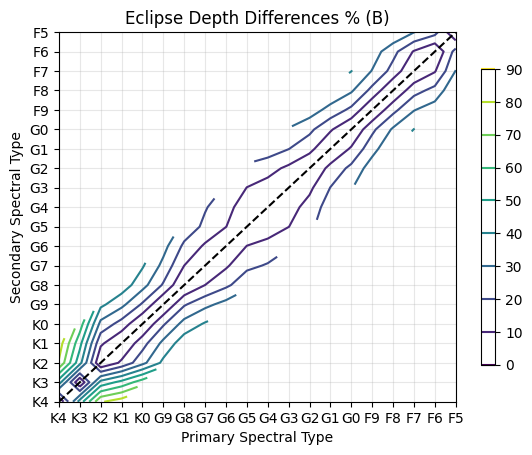

In [6]:
fig, ax = plt.subplots()  
CS = ax.contour(plot_B*100, levels=8)
CB = fig.colorbar(CS, shrink=0.8)
ax.plot([0, 19], [0, 19], 'k--')
ax.grid(True, alpha=0.3)

ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
ax.set_xticklabels(spT)
ax.set_yticklabels(spT)

ax.set_xlabel('Primary Spectral Type')
ax.set_ylabel('Secondary Spectral Type')
ax.set_title('Eclipse Depth Differences % (B)')
plt.show()

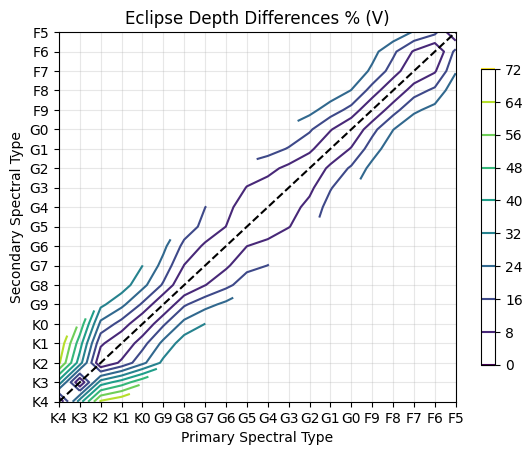

In [7]:
fig, ax = plt.subplots()  
CS = ax.contour(plot_V*100, levels=8)
CB = fig.colorbar(CS, shrink=0.8)
ax.plot([0, 19], [0, 19], 'k--')
ax.grid(True, alpha=0.3)

ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
ax.set_xticklabels(spT)
ax.set_yticklabels(spT)

ax.set_xlabel('Primary Spectral Type')
ax.set_ylabel('Secondary Spectral Type')
ax.set_title('Eclipse Depth Differences % (V)')
plt.show()

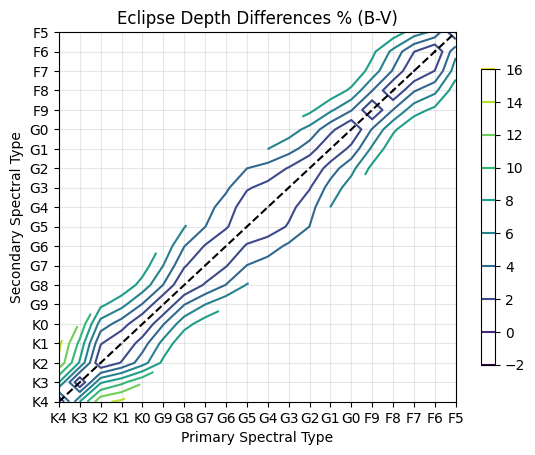

In [8]:
fig, ax = plt.subplots()  
CS = ax.contour((plot_B - plot_V)*100, levels=8)
CB = fig.colorbar(CS, shrink=0.8)
ax.plot([0, 19], [0, 19], 'k--')
ax.grid(True, alpha=0.3)

ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
ax.set_xticklabels(spT)
ax.set_yticklabels(spT)

ax.set_xlabel('Primary Spectral Type')
ax.set_ylabel('Secondary Spectral Type')
ax.set_title('Eclipse Depth Differences % (B-V)')
plt.show()

### Eclipse Widths

This does not give any indication on the $T_\text{eff}$ of the binary components, but gives good indication on $R$.

In [6]:
plot_prim = np.full_like(np.zeros((20, 20)), np.nan)
plot_sec = np.full_like(np.zeros((20, 20)), np.nan)

for primary in widths:
    prim_idx = spT_plot[primary]
    
    identical_width = 0.0
    for secondary in widths[primary]:
        if primary == secondary: 
            identical_width = np.mean(widths[primary][secondary].B)
            break
    
    for secondary in widths[primary]:
        sec_idx = spT_plot[secondary]
        b = widths[primary][secondary].B
        v = widths[primary][secondary].V
        
        prim_width = b[0]
        sec_width = b[1]
        
        plot_prim[prim_idx][sec_idx] = np.abs((prim_width - identical_width) / identical_width)
        plot_sec[prim_idx][sec_idx] = np.abs((sec_width - identical_width) / identical_width)

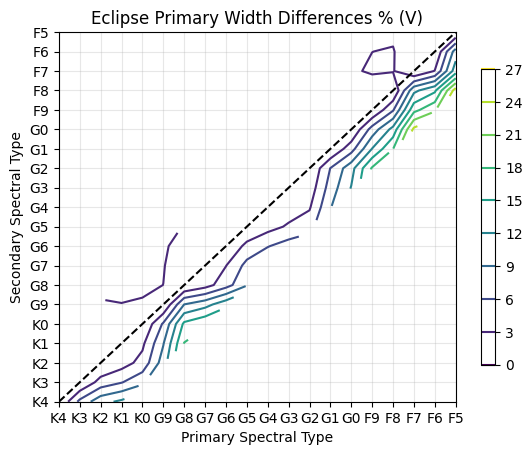

In [10]:
fig, ax = plt.subplots()  
CS = ax.contour(plot_prim*100, levels=8)
CB = fig.colorbar(CS, shrink=0.8)
ax.plot([0, 19], [0, 19], 'k--')
ax.grid(True, alpha=0.3)

ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
ax.set_xticklabels(spT)
ax.set_yticklabels(spT)

ax.set_xlabel('Primary Spectral Type')
ax.set_ylabel('Secondary Spectral Type')
ax.set_title('Eclipse Primary Width Differences % (V)')
plt.show()

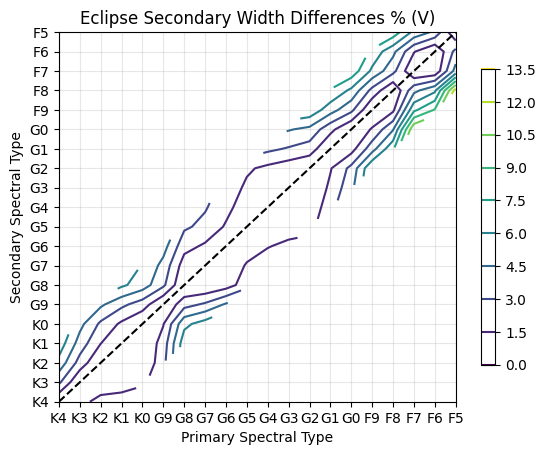

In [11]:
fig, ax = plt.subplots()  
CS = ax.contour(plot_sec*100, levels=8)
CB = fig.colorbar(CS, shrink=0.8)
ax.plot([0, 19], [0, 19], 'k--')
ax.grid(True, alpha=0.3)

ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
ax.set_xticklabels(spT)
ax.set_yticklabels(spT)

ax.set_xlabel('Primary Spectral Type')
ax.set_ylabel('Secondary Spectral Type')
ax.set_title('Eclipse Secondary Width Differences % (V)')
plt.show()

## Data Storage

Store process data in Pandas dataframe and store in a database for future querying.

In [15]:
b_v = [1.090, 0.990, 0.884, 0.857, 0.816, 0.775, 0.730, 0.710, .700, .680, .670, .660, .650, .622, .595, .560, .530, .500, .486, .440]
bp_rp = [1.34, 1.21, 1.10, 1.01, .983, .950, .900, .880, .869, .850, .841, .832, .823, .803, .784, .719, .694, .670, .640, .587]

flattened_data = [{"Primary SpT" : primary_key[0], 
                   "Primary T" : 10**3 * teff[spT_plot[primary_key[0]]], 
                   "Primary R" : radii[spT_plot[primary_key[0]]],
                   "Primary M" : masses[spT_plot[primary_key[0]]],
                   "Primary B-V" : bv_i,
                   "Primary BP-RP" : bp_rpi,
                   
                   "Secondary SpT" : secondary_key, 
                   "Secondary T" : 10**3 * teff[spT_plot[secondary_key]],
                   "Secondary R" : radii[spT_plot[secondary_key]],
                   "Secondary M" : masses[spT_plot[secondary_key]],
                   "Depth Difference" : plot_V[spT_plot[primary_key[0]]][spT_plot[secondary_key]]*100, 
                   "Width Difference" : 100*plot_prim[spT_plot[primary_key[0]]][spT_plot[secondary_key]]}
                  
                  for primary_key, bv_i, bp_rpi in zip(depths.items(), b_v, bp_rp)
                  for secondary_key, _ in primary_key[1].items()
                  ]

df = pd.DataFrame(flattened_data)
df

,Primary SpT,Primary T,Primary R,Primary M,Primary B-V,Primary BP-RP,Secondary SpT,Secondary T,Secondary R,Secondary M,Depth Difference,Width Difference
0,K4,4600.0,0.713,0.73,1.090,1.340,K4,4600.0,0.713,0.73,3.715694e-10,0.009409
1,K4,4600.0,0.713,0.73,1.090,1.340,K3,4830.0,0.755,0.78,3.651717e+01,6.804823
2,K4,4600.0,0.713,0.73,1.090,1.340,K2,5100.0,0.783,0.82,6.540312e+01,11.020189
3,K4,4600.0,0.713,0.73,1.090,1.340,K1,5170.0,0.797,0.86,7.089773e+01,12.613839
4,K3,4830.0,0.755,0.78,0.990,1.210,K4,4600.0,0.713,0.73,3.651717e+01,2.548003
...,...,...,...,...,...,...,...,...,...,...,...,...
123,F6,6350.0,1.359,1.25,0.486,0.640,F5,6550.0,1.473,1.33,1.819753e+01,10.427601
124,F5,6550.0,1.473,1.33,0.440,0.587,F8,6180.0,1.221,1.18,2.988595e+01,2.586560
125,F5,6550.0,1.473,1.33,0.440,0.587,F7,6280.0,1.324,1.21,2.325944e+01,2.399068
126,F5,6550.0,1.473,1.33,0.440,0.587,F6,6350.0,1.359,1.25,1.819620e+01,2.435790


In [16]:
import sqlite3

conn = sqlite3.connect('binarystargrid.db')
df.to_sql('F5-K4', conn, if_exists='replace', index=False)

128